Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [ ]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

# Model Zoo -- ResNet-34 MNIST Digits Classifier

### Network Architecture

The network in this notebook is an implementation of the ResNet-34 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] http://yann.lecun.com/exdb/mnist/

![](../images/resnets/resnet34/resnet34-arch.png)


The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](../images/resnets/resnet-ex-1-1.png)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](../images/resnets/resnet-ex-1-2.png)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [ ]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28

# Other
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GRAYSCALE = True

### MNIST Dataset

In [ ]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = MNIST(root='data', 
                      train=True, 
                      transform=transforms.ToTensor(),
                      download=True)

test_dataset = MNIST(root='data', 
                     train=False, 
                     transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print(DEVICE)
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

cuda
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [ ]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):
    for batch_idx, (x, y) in enumerate(train_loader):
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## Model

In [ ]:
from google.colab import drive


drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys


PATH = "/content/drive/My Drive/Colab Notebooks/EECS553ML_reproduce/"
sys.path.append(PATH)

In [ ]:
from resnet34 import resnet34


torch.manual_seed(RANDOM_SEED)
model = resnet34()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [ ]:
from trainer import Trainer


trainer = Trainer(model, train_loader, DEVICE)

Training on cuda


In [ ]:
trainer.train(LEARNING_RATE, NUM_EPOCHS)

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.5538
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.2856
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.0649
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.1078
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.1564
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.0635
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.0481
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.1195
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.0313
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0880
Epoch: 001/010 | Train: 98.038%
Time elapsed: 0.56 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0393
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0767
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.1274
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0517
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0128
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0181
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0456
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0263
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0256
Epoch: 002/010 | Batch 0450/0469 

## Evaluation

In [ ]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (trainer.compute_accuracy(test_loader)))

Test accuracy: 99.04%


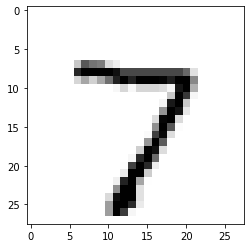

In [ ]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [ ]:
trainer.model.eval()
logits, probas = trainer.model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

In [ ]:
#%watermark -iv

In [ ]:
torch.save(model.state_dict(), f"{PATH}mnist_resnet34_model.t7")